# Training All 25 Trials

## Library Imports

In [1]:
from autogluon.multimodal import MultiModalPredictor
from ray import tune
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import os

torch.set_float32_matmul_precision("medium")

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-29 01:53:46,367	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-29 01:53:46,488	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
NUM_TRIALS = 25

## Data Imports

In [3]:
train_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/train_df.csv")
test_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/test_df.csv")

## Finetuning EfficientNet B2

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [4]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [5]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path_efficientnet_b2 = "../../model/master/" + f"train_EfficientNetB2_25_trials_{timestamp_str}"

In [6]:
model_path_efficientnet_b2

'../../model/master/train_EfficientNetB2_25_trials_2024-12-29_01-53-46'

In [7]:
os.makedirs(model_path_efficientnet_b2, exist_ok=True)

Defining Hyperparameters

In [8]:
hyperparameters_efficientnet_b2 = {
    "optimization.learning_rate": tune.loguniform(0.00001, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(2, 3),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "efficientnet_b2",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [9]:
predictor_efficientnet_b2 = MultiModalPredictor(label="label_text", path=model_path_efficientnet_b2, problem_type='multiclass', eval_metric="f1_macro")

In [10]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": NUM_TRIALS
}

In [11]:
predictor_efficientnet_b2.fit(
        train_data=train_df,
        hyperparameters=hyperparameters_efficientnet_b2,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       112.15 GB / 127.91 GB (87.7%)
Disk Space Avail:   1397.11 GB / 1863.00 GB (75.0%)


Trial name,should_checkpoint,val_f1_macro
05e58eb4,True,0.99548
0bafbc14,True,0.734989
191f2280,True,0.98985
27e6d9d5,True,0.170453
2f5cc77b,True,0.792996
2f956e35,True,0.96732
38fb6fe0,True,0.989048
3bd98b70,True,0.929322
4c7e3852,True,0.176223
688c9834,True,0.434458


Removing non-optimal trials and only keep the best one.
e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\autogluon\multimodal\utils\checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues

## Evaluate on Test Dataset

In [12]:
scores_efficientnet_b2 = predictor_efficientnet_b2.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores_efficientnet_b2

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 12.66it/s]


{'f1_macro': 0.8599611423377521,
 'f1_micro': 0.8680738786279684,
 'accuracy': 0.8680738786279684,
 'recall_macro': 0.8451513127237765,
 'precision_macro': 0.8776017568694371}

In [13]:
preds_efficientnet_b2 = predictor_efficientnet_b2.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 15.53it/s]


In [14]:
true_labels = test_df['label_text']

# Classification Report

In [15]:
cr = classification_report(true_labels, preds_efficientnet_b2)

In [16]:
print(cr)

              precision    recall  f1-score   support

 empty_bunch       0.95      0.83      0.88        23
    overripe       0.89      0.87      0.88        54
        ripe       0.88      0.86      0.87       154
      rotten       0.71      0.62      0.67         8
   underripe       0.83      0.89      0.86       130
      unripe       1.00      1.00      1.00        10

    accuracy                           0.87       379
   macro avg       0.88      0.85      0.86       379
weighted avg       0.87      0.87      0.87       379



In [17]:
cm = confusion_matrix(true_labels, preds_efficientnet_b2)

In [18]:
cm

array([[ 19,   2,   0,   2,   0,   0],
       [  0,  47,   4,   0,   3,   0],
       [  1,   2, 132,   0,  19,   0],
       [  0,   1,   1,   5,   1,   0],
       [  0,   1,  13,   0, 116,   0],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

Accuracy per Class

In [19]:
cm.diagonal()/cm.sum(axis=1)

array([0.82608696, 0.87037037, 0.85714286, 0.625     , 0.89230769,
       1.        ])

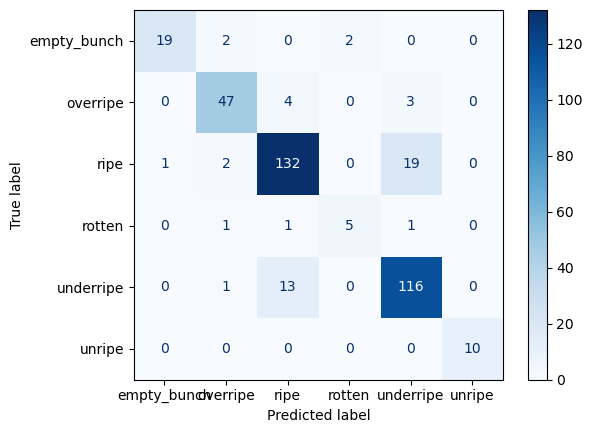

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor_efficientnet_b2.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Save Raw TIMM Format

In [21]:
predictor_efficientnet_b2.dump_model(model_path_efficientnet_b2 + "/timm")

Model timm_image weights saved to ../../model/master/train_EfficientNetB2_25_trials_2024-12-29_01-53-46/timm\timm_image/pytorch_model.bin.
Timm config saved to ../../model/master/train_EfficientNetB2_25_trials_2024-12-29_01-53-46/timm\timm_image/config.json.


'../../model/master/train_EfficientNetB2_25_trials_2024-12-29_01-53-46/timm'

## Finetuning ResNet 18

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [22]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [23]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path_resnet18 = "../../model/master/" + f"train_resnet18_25_trials_{timestamp_str}"

In [24]:
model_path_resnet18

'../../model/master/train_resnet18_25_trials_2024-12-29_02-51-33'

In [25]:
os.makedirs(model_path_resnet18, exist_ok=True)

Defining Hyperparameters

In [26]:
hyperparameters_resnet18 = {
    "optimization.learning_rate": tune.loguniform(0.00001, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(2, 3),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "resnet18",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [27]:
predictor_resnet18 = MultiModalPredictor(label="label_text", path=model_path_resnet18, problem_type='multiclass', eval_metric="f1_macro")

In [28]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": NUM_TRIALS
}

In [29]:
predictor_resnet18.fit(
        train_data=train_df,
        hyperparameters=hyperparameters_resnet18,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       111.12 GB / 127.91 GB (86.9%)
Disk Space Avail:   1397.05 GB / 1863.00 GB (75.0%)


Trial name,should_checkpoint,val_f1_macro
05b49d79,True,0.107429
0d22492d,True,0.161934
1221b546,True,0.937967
15d988fe,True,0.122284
1824fce3,True,0.79519
1da2a585,True,0.129021
1dd88144,True,0.102003
203444a3,True,0.131586
27f68f62,True,0.150512
293a7be4,True,0.760207


2024-12-29 02:54:42,623	ERROR tune_controller.py:1331 -- Trial task failed for trial ad705b62
Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\worker.py", line 2691, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Evaluate on Test Dataset

In [30]:
scores_resnet18 = predictor_resnet18.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores_resnet18

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 20.25it/s]


{'f1_macro': 0.8784119031245466,
 'f1_micro': 0.8759894459102903,
 'accuracy': 0.8759894459102903,
 'recall_macro': 0.9202275448652261,
 'precision_macro': 0.8501579937854448}

In [31]:
preds_resnet18 = predictor_resnet18.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 23.62it/s]


In [32]:
true_labels = test_df['label_text']

# Classification Report

In [33]:
cr = classification_report(true_labels, preds_resnet18)

In [34]:
print(cr)

              precision    recall  f1-score   support

 empty_bunch       0.91      0.87      0.89        23
    overripe       0.93      0.93      0.93        54
        ripe       0.93      0.82      0.87       154
      rotten       0.80      1.00      0.89         8
   underripe       0.83      0.91      0.86       130
      unripe       0.71      1.00      0.83        10

    accuracy                           0.88       379
   macro avg       0.85      0.92      0.88       379
weighted avg       0.88      0.88      0.88       379



In [35]:
cm = confusion_matrix(true_labels, preds_resnet18)

In [36]:
cm

array([[ 20,   1,   0,   2,   0,   0],
       [  2,  50,   1,   0,   1,   0],
       [  0,   2, 126,   0,  24,   2],
       [  0,   0,   0,   8,   0,   0],
       [  0,   1,   9,   0, 118,   2],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

Accuracy per Class

In [37]:
cm.diagonal()/cm.sum(axis=1)

array([0.86956522, 0.92592593, 0.81818182, 1.        , 0.90769231,
       1.        ])

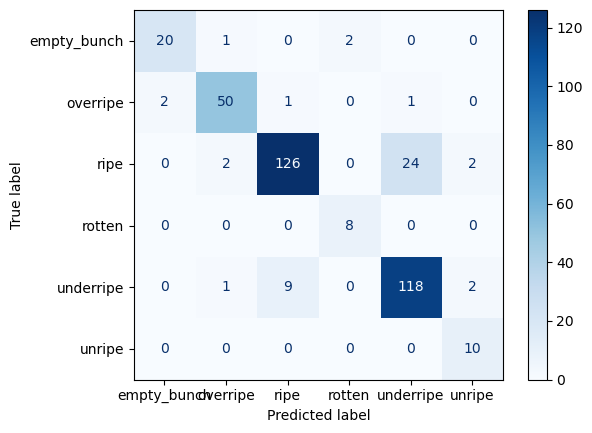

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor_resnet18.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Save Raw TIMM Format

In [39]:
predictor_resnet18.dump_model(model_path_resnet18 + "/timm")

Model timm_image weights saved to ../../model/master/train_resnet18_25_trials_2024-12-29_02-51-33/timm\timm_image/pytorch_model.bin.
Timm config saved to ../../model/master/train_resnet18_25_trials_2024-12-29_02-51-33/timm\timm_image/config.json.


'../../model/master/train_resnet18_25_trials_2024-12-29_02-51-33/timm'

## Finetuning EfficientNet V2

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [40]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [41]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path_efficientnetv2 = "../../model/master/" + f"train_efficientnetv2_25_trials_{timestamp_str}"

In [42]:
model_path_efficientnetv2

'../../model/master/train_resnet18_25_trials_2024-12-29_03-18-28'

In [43]:
os.makedirs(model_path_efficientnetv2, exist_ok=True)

Defining Hyperparameters

In [44]:
hyperparameters_efficientnetv2 = {
    "optimization.learning_rate": tune.loguniform(0.00001, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(2, 3),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "tf_efficientnetv2_s.in1k",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [45]:
predictor_efficientnetv2 = MultiModalPredictor(label="label_text", path=model_path_efficientnetv2, problem_type='multiclass', eval_metric="f1_macro")

In [46]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": NUM_TRIALS
}

In [47]:
predictor_efficientnetv2.fit(
        train_data=train_df,
        hyperparameters=hyperparameters_efficientnetv2,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       110.87 GB / 127.91 GB (86.7%)
Disk Space Avail:   1396.97 GB / 1863.00 GB (75.0%)


Trial name,should_checkpoint,val_f1_macro
036ae5ea,True,0.756984
050c8c73,True,0.375277
095e97bf,True,0.172222
1022eb56,True,0.23147
157a33e8,True,0.153861
18543255,True,0.986859
1efce132,True,0.239314
2eb0a1f0,True,0.969434
37fa4378,True,0.376293
3eadc296,True,0.366108


Removing non-optimal trials and only keep the best one.
e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\autogluon\multimodal\utils\checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues

## Evaluate on Test Dataset

In [48]:
scores_efficientnetv2 = predictor_efficientnetv2.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores_efficientnetv2

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


{'f1_macro': 0.878706151794059,
 'f1_micro': 0.8891820580474934,
 'accuracy': 0.8891820580474934,
 'recall_macro': 0.8822799181494835,
 'precision_macro': 0.8789420438584741}

In [49]:
preds_efficientnetv2 = predictor_efficientnetv2.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


In [50]:
true_labels = test_df['label_text']

# Classification Report

In [51]:
cr = classification_report(true_labels, preds_efficientnetv2)

In [52]:
print(cr)

              precision    recall  f1-score   support

 empty_bunch       0.81      0.91      0.86        23
    overripe       0.92      0.83      0.87        54
        ripe       0.91      0.89      0.90       154
      rotten       0.86      0.75      0.80         8
   underripe       0.87      0.91      0.89       130
      unripe       0.91      1.00      0.95        10

    accuracy                           0.89       379
   macro avg       0.88      0.88      0.88       379
weighted avg       0.89      0.89      0.89       379



In [53]:
cm = confusion_matrix(true_labels, preds_efficientnetv2)

In [54]:
cm

array([[ 21,   1,   0,   1,   0,   0],
       [  5,  45,   2,   0,   2,   0],
       [  0,   3, 137,   0,  13,   1],
       [  0,   0,   0,   6,   2,   0],
       [  0,   0,  12,   0, 118,   0],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

Accuracy per Class

In [55]:
cm.diagonal()/cm.sum(axis=1)

array([0.91304348, 0.83333333, 0.88961039, 0.75      , 0.90769231,
       1.        ])

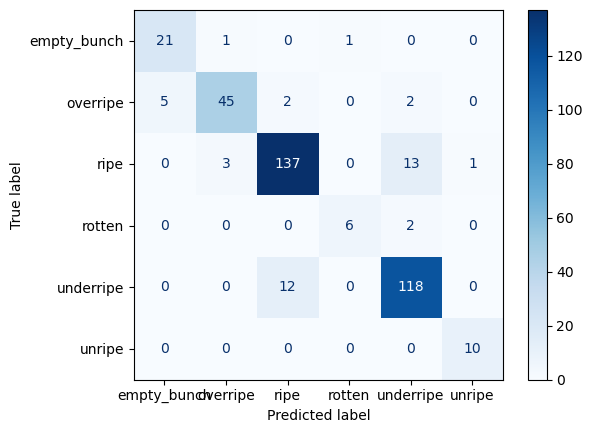

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor_efficientnetv2.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Save Raw TIMM Format

In [57]:
predictor_efficientnetv2.dump_model(model_path_efficientnetv2 + "/timm")

Model timm_image weights saved to ../../model/master/train_resnet18_25_trials_2024-12-29_03-18-28/timm\timm_image/pytorch_model.bin.
Timm config saved to ../../model/master/train_resnet18_25_trials_2024-12-29_03-18-28/timm\timm_image/config.json.


'../../model/master/train_resnet18_25_trials_2024-12-29_03-18-28/timm'